# Performing z-mu cosmology fitting

In [1]:
import cosmographi as cg
import caskade as ck
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from time import time

print(jax.config.jax_enable_x64)

True


## Making a SN sample

In [2]:
# Define the simulator
cosmology = cg.Cosmology()
rateIa = cg.sn.SNRateConst(cosmology, 1e-4, z_min=0.0, z_max=2.0, name="rateIa")
rateIbc = cg.sn.SNRateConst(cosmology, 5e-5, z_min=0.0, z_max=2.0, name="rateIbc")
ratecombined = cg.sn.CombinedSNRate((rateIa, rateIbc), z_min=0.0, z_max=2.0, cosmology=cosmology)
detect_Ia = cg.sn.MuSigmoidDetect(threshold=15, scale=0.1, name="detectIa")
detect_Ibc = cg.sn.MuSigmoidDetect(threshold=14, scale=0.1, name="detectIbc")

# Define sampling parameters
n_samples = 500
var_mu_Ia = lambda z: 0.2**2 * z
var_z_Ia = lambda z: 0.1**2 * z
cov_Ia = lambda key, vmu, vz: jax.random.uniform(
    key, vmu.shape, minval=0, maxval=jnp.sqrt(vmu * vz) * 0.7
)
var_mu_Ibc = lambda z: 1.5**2 * z
var_z_Ibc = lambda z: 0.2**2 * z
cov_Ibc = lambda key, vmu, vz: jax.random.uniform(
    key, vmu.shape, minval=0, maxval=jnp.sqrt(vmu * vz) * 0.7
)

# Sample SN
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
# sample SN redshifts
z = ratecombined.sample(subkey, n_samples)
# compute true distance modulus
DL = jax.vmap(cosmology.luminosity_distance)(z)
mu = 5 * jnp.log10(DL) - 5
# sample SN types
t = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    t.append(ratecombined.sample_type(subkey, z[i]))
t = jnp.array(t)
# determine observational uncertainties
var_z = jnp.stack((var_z_Ia(z), var_z_Ibc(z)), axis=-1)  # (N, t)
var_mu = jnp.stack((var_mu_Ia(z), var_mu_Ibc(z)), axis=-1)  # (N, t)
key, subkey1 = jax.random.split(key)
key, subkey2 = jax.random.split(key)
cov = jnp.stack(
    (cov_Ia(subkey1, var_mu[:, 0], var_z[:, 0]), cov_Ibc(subkey2, var_mu[:, 1], var_z[:, 1])),
    axis=-1,
)  # (N, t)
key, subkey = jax.random.split(key)
# sample observed redshift and distance modulus
samp_varz = jnp.where(t == 0, var_z[:, 0], var_z[:, 1])
samp_varmu = jnp.where(t == 0, var_mu[:, 0], var_mu[:, 1])
samp_cov = jnp.where(t == 0, cov[:, 0], cov[:, 1])
obs = jax.random.multivariate_normal(
    key,
    mean=jnp.stack((z, mu), axis=-1),
    cov=jnp.stack(
        (jnp.stack((samp_varz, samp_cov), axis=-1), jnp.stack((samp_cov, samp_varmu), axis=-1)),
        axis=-1,
    ),
)
obs_z = obs[:, 0]  # (N,)
obs_mu = obs[:, 1]  # (N,)
obs_mean = jnp.stack((obs_z, obs_mu), axis=-1)  # (N, 2)
obs_cov = jnp.stack(
    (
        jnp.stack((var_z, cov), axis=-1),
        jnp.stack((cov, var_mu), axis=-1),
    ),
    axis=-1,
)  # (N, t, 2, 2)
print(obs_mean.shape, obs_cov.shape)
# sample detections
detected = []
for i in range(n_samples):
    key, subkey = jax.random.split(key)
    if t[i] == 0:
        detected.append(detect_Ia.sample(subkey, obs_z[i], obs_mu[i]))
    else:
        detected.append(detect_Ibc.sample(subkey, obs_z[i], obs_mu[i]))
detected = jnp.array(detected)
obs_mean_detected = obs_mean[detected]
obs_cov_detected = obs_cov[detected]

(500, 2) (500, 2, 2, 2)


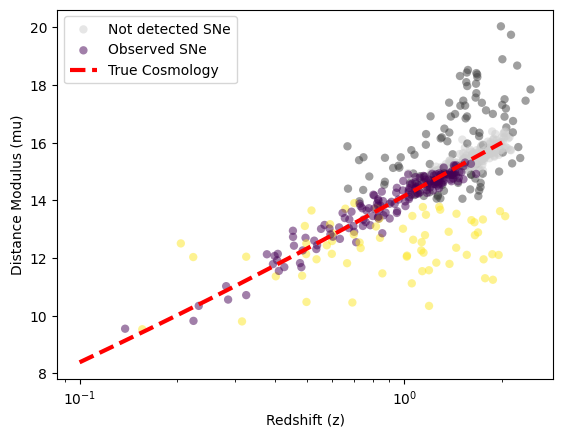

In [3]:
plt.scatter(
    obs_z[~detected],
    obs_mu[~detected],
    c=plt.get_cmap("Greys")(0.5 * t[~detected] + 0.3),
    alpha=0.5,
    label="Not detected SNe",
    linewidth=0,
)
plt.scatter(
    obs_z[detected],
    obs_mu[detected],
    c=t[detected],
    cmap="viridis",
    alpha=0.5,
    label="Observed SNe",
    linewidth=0,
)
z_line = jnp.linspace(0.1, 2, 1000)
plt.plot(
    z_line,
    5 * jnp.log10(jax.vmap(cosmology.luminosity_distance)(z_line)) - 5,
    "r--",
    label="True Cosmology",
    linewidth=3,
)
plt.xlabel("Redshift (z)")
plt.xscale("log")
plt.ylabel("Distance Modulus (mu)")
plt.legend()
plt.show()

## Construct posterior density

In [4]:
cosmo_mean = jnp.array([0.307, -1])  # Omega_m, w
cosmo_cov = jnp.array([[0.1, 0], [0, 1.0]])
cosmology.Omega_m.to_dynamic()
cosmology.w0.to_dynamic()

detect_Ia_mean = jnp.array([15, 0.1])  # threshold, scale
detect_Ia_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ia.threshold.to_dynamic()
# detect_Ia.scale.to_dynamic()

detect_Ibc_mean = jnp.array([14, 0.1])  # threshold, scale
detect_Ibc_cov = jnp.array([[1.0, 0], [0, 0.01]])
# detect_Ibc.threshold.to_dynamic()
# detect_Ibc.scale.to_dynamic()

In [ ]:
class Likelihood(ck.Module):
    def __init__(
        self,
        cosmology: cg.Cosmology,
        ratecombined: cg.sn.CombinedSNRate,
        detect_Ia: cg.sn.MuSigmoidDetect,
        detect_Ibc: cg.sn.MuSigmoidDetect,
        obs_mean: jnp.ndarray,
        obs_cov: jnp.ndarray,
        name=None,
    ):
        super().__init__(name=name)
        self.cosmology = cosmology
        self.rate = ratecombined
        self.detect = [detect_Ia, detect_Ibc]
        self.obs_mean = obs_mean
        self.obs_cov = obs_cov
        self.z = ck.Param("z", z[detected], description="Intrinsic redshift")
        self.vsll = jax.vmap(
            lambda _xy, _i, _t: self.logP_zmu_theta(_i, _xy, t=_t), in_axes=(0, None, None)
        )

    @ck.forward
    def logP_zt_theta(self, i, z=None, t=None):
        # P(z| Omega, phi_t)
        pz = self.rate.logPz(z[i])
        # P(t|z, Omega, phi_t)
        pt = self.rate.logPt_z(t, z[i])
        return pz + pt

    @ck.forward
    def Z_zmu_theta(self, i, t):
        z_obs = cg.utils.midpoints(self.rate.z_min, self.rate.z_max, 100)
        mu_obs = cg.utils.midpoints(8, 22, 100)
        xy = jnp.stack(jnp.meshgrid(z_obs, mu_obs, indexing="ij"), axis=-1)
        dA = (z_obs[1] - z_obs[0]) * (mu_obs[1] - mu_obs[0])
        return jax.nn.logsumexp(self.vsll(xy.reshape(-1, 2), i, t)) + jnp.log(dA)

    @ck.forward
    def logP_zmu_theta(self, i, zmu_obs, z=None, t=None):
        mu = 5 * jnp.log10(self.cosmology.luminosity_distance(z[i])) - 5
        zmu = jnp.stack((z[i], mu), axis=-1)
        r = zmu - zmu_obs
        # P(z_obs, mu_obs | z, mu, theta)
        po = -0.5 * (
            jnp.linalg.slogdet(self.obs_cov[i][t])[1]
            + jnp.dot(r, jnp.linalg.solve(self.obs_cov[i][t], r))
        )
        # P(d=1 | z_obs, mu_obs, t)
        pd = self.detect[t].log_prob(zmu_obs[0], zmu_obs[1])
        return po + pd

    @ck.forward
    def _log_likelihood(self, i):
        log_likelihood = []

        for t in range(len(self.detect)):
            # P(z, t | theta)
            ll = self.logP_zt_theta(i, t=t)
            # P(zobs, muobs | Omega, z, mu, d=1, t)
            ll = ll + self.logP_zmu_theta(i, self.obs_mean[i], t=t) - self.Z_zmu_theta(i, t)
            log_likelihood.append(ll)
        return jax.nn.logsumexp(jnp.array(log_likelihood))

    @ck.forward
    def log_likelihood(self):
        return jax.vmap(self._log_likelihood)(jnp.arange(len(self.obs_mean))).sum()


class Prior(ck.Module):
    def __init__(self, cosmology, detect_Ia, detect_Ibc, name=None):
        super().__init__(name=name)
        self.cosmology = cosmology
        self.detect = [detect_Ia, detect_Ibc]

    @ck.forward
    def log_prior(self):
        prior = 0
        # Cosmology prior
        params = jnp.array([self.cosmology.Omega_m.value, self.cosmology.w0.value])
        diff = params - jnp.array(cosmo_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(cosmo_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(cosmo_cov)[1])
        prior = prior + norm + exponent

        # Detect_Ia prior
        params = jnp.array([self.detect[0].threshold.value, self.detect[0].scale.value])
        diff = params - jnp.array(detect_Ia_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ia_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ia_cov)[1])
        prior = prior + norm + exponent

        # Detect_Ibc prior
        params = jnp.array([self.detect[1].threshold.value, self.detect[1].scale.value])
        diff = params - jnp.array(detect_Ibc_mean)
        exponent = -0.5 * jnp.dot(diff, jnp.linalg.solve(detect_Ibc_cov, diff))
        norm = -0.5 * (len(params) * jnp.log(2 * jnp.pi) + jnp.linalg.slogdet(detect_Ibc_cov)[1])
        prior = prior + norm + exponent
        return prior


class Posterior(ck.Module):
    def __init__(self, likelihood, prior, name=None):
        super().__init__(name=name)
        self.likelihood = likelihood
        self.prior = prior

    @ck.forward
    def log_posterior(self):
        log_prior = self.prior.log_prior()
        log_likelihood = self.likelihood.log_likelihood()
        return log_prior + log_likelihood

In [6]:
posterior = Posterior(
    likelihood=Likelihood(
        cosmology,
        ratecombined,
        detect_Ia,
        detect_Ibc,
        obs_mean_detected,
        obs_cov_detected,
        name="likelihood",
    ),
    prior=Prior(cosmology, detect_Ia, detect_Ibc),
)

start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)
start = time()
print(posterior.log_posterior())
print("Time taken (s):", time() - start)

-4811.348155600571
Time taken (s): 6.653274297714233
-4811.348155600571
Time taken (s): 0.5915317535400391
-4811.348155600571
Time taken (s): 0.605231761932373
-4811.348155600571
Time taken (s): 0.6563265323638916


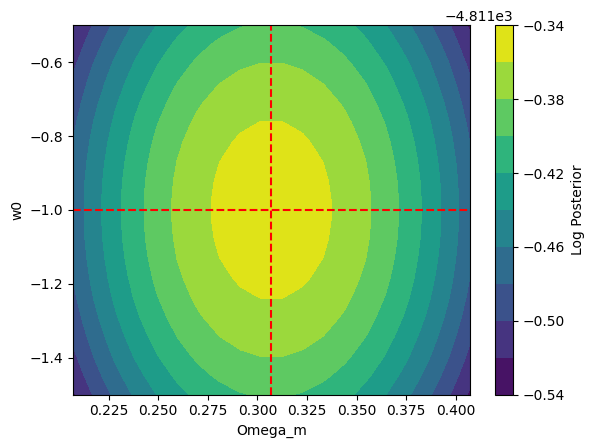

In [7]:
Om = jnp.linspace(0.207, 0.407, 20)
Ow = jnp.linspace(-1.5, -0.5, 20)
x = jnp.stack(jnp.meshgrid(Om, Ow, indexing="ij"), axis=-1)
Lp = jax.vmap(posterior.log_posterior)(x.reshape(-1, 2)).reshape(20, 20)
plt.contourf(Om, Ow, Lp, levels=10, cmap="viridis")
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.colorbar(label="Log Posterior")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.show()

In [ ]:
posterior.likelihood.z.to_dynamic()
x0 = posterior.build_params_array()
print(x0.shape)

chains = 16
key, subkey = jax.random.split(key)

# warmup
key, subkey = jax.random.split(key)
samples = cg.utils.mala(
    jnp.repeat(x0[None, :], chains, axis=0),
    posterior.log_posterior,
    num_samples=100,
    epsilon=0.01,
    key=subkey,
    progress=True,
)
cov = jnp.cov(samples[10:].reshape(-1, samples.shape[-1]).T)
print(cov.shape)

# production
key, subkey = jax.random.split(key)
samples = cg.utils.mala(
    samples[-1],
    posterior.log_posterior,
    mass_matrix=cov,
    num_samples=1000,
    epsilon=0.05,
    key=subkey,
    progress=True,
)

(227,)


MALA: 100%|██████████| 100/100 [17:50<00:00, 10.70s/it, acc_rate=0.56]


(227, 227)


MALA:  24%|██▍       | 239/1000 [40:17<2:08:16, 10.11s/it, acc_rate=0.31]


KeyboardInterrupt: 

AttributeError: module 'cosmographi.utils' has no attribute 'corner_plot'

In [28]:
print(posterior.dynamic_params)
print(posterior)

(Omega_m, w0, z)
Posterior|Posterior
    likelihood|Likelihood
        Cosmology|Cosmology
            H0|static: 67.9
            Omega_m|dynamic value: 0.307
            Omega_k|static: 0
            Omega_r|static: 0
            Omega_l|pointer
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
            w0|dynamic value: -1
            wa|static: 0
        CombinedSNRate|CombinedSNRate
            Cosmology|Cosmology
                H0|static: 67.9
                Omega_m|dynamic value: 0.307
                Omega_k|static: 0
                Omega_r|static: 0
                Omega_l|pointer
                    Omega_m|dynamic value: 0.307
                    Omega_k|static: 0
                    Omega_r|static: 0
                w0|dynamic value: -1
                wa|static: 0
            sn_rates|ntuple
                rateIa|SNRateConst
                    Cosmology|Cosmology
                        H0|static: 67.9


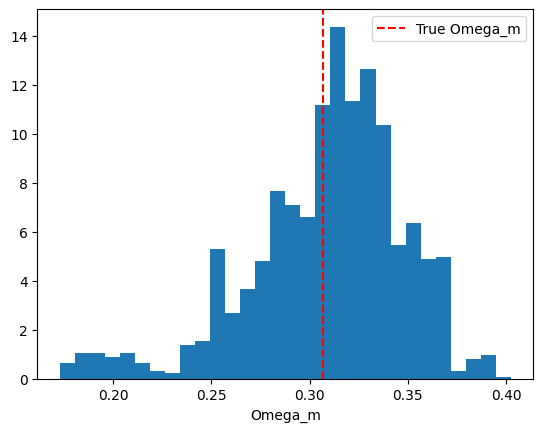

In [23]:
plt.hist(samples[:, :, 0].reshape(-1), bins=30, density=True)
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.xlabel("Omega_m")
plt.legend()
plt.show()

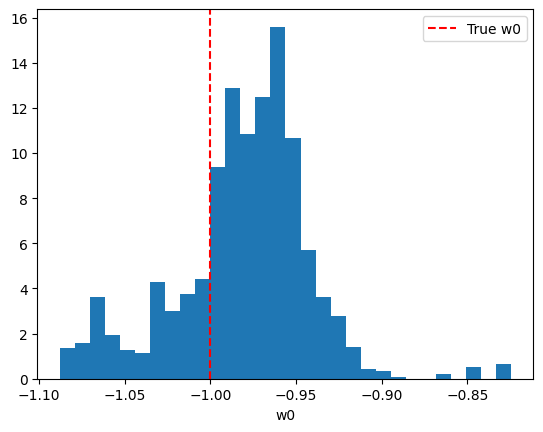

In [ ]:
plt.hist(samples[:, :, 1].reshape(-1), bins=30, density=True)
plt.axvline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.xlabel("w0")
plt.legend()
plt.show()

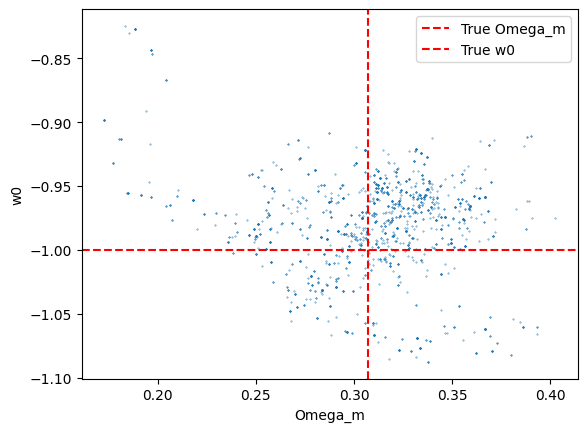

In [ ]:
plt.scatter(samples[:, :, 0].reshape(-1), samples[:, :, 1].reshape(-1), s=0.1)
plt.axvline(cosmo_mean[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(cosmo_mean[1], color="r", linestyle="--", label="True w0")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.legend()
plt.show()

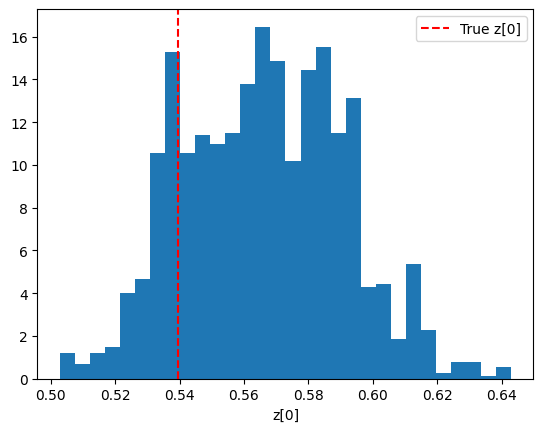

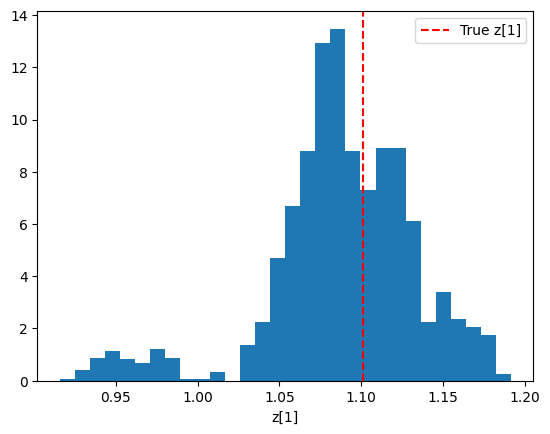

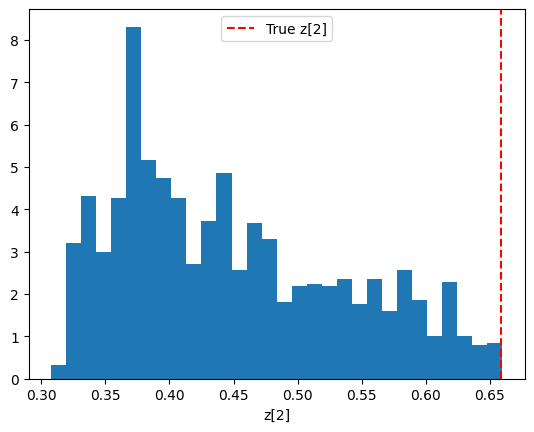

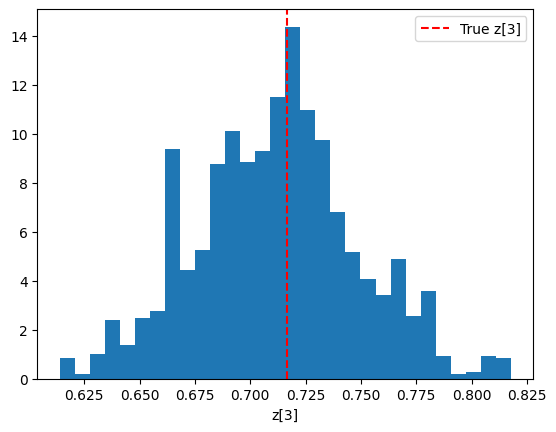

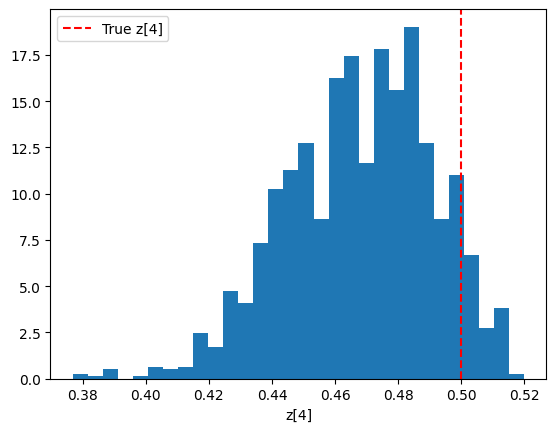

In [ ]:
for i in range(5):
    plt.hist(samples[:, :, 2 + i].reshape(-1), bins=30, density=True)
    plt.axvline(x0[2 + i], color="r", linestyle="--", label=f"True z[{i}]")
    plt.xlabel(f"z[{i}]")
    plt.legend()
    plt.show()

In [27]:
len(x0)

227

In [32]:
# cov = jnp.cov(samples.reshape(-1, samples.shape[-1]).T)
cov = jnp.diag(
    jnp.var(samples.reshape(-1, samples.shape[-1]), axis=0)
)  # use only diagonal covariance
print(cov.shape)

# production
key, subkey = jax.random.split(key)
samples_prod = cg.utils.mala(
    samples[-1],
    posterior.log_posterior,
    mass_matrix=cov,
    num_samples=100,
    epsilon=0.1,
    key=subkey,
    progress=True,
)

(227, 227)


MALA: 100%|██████████| 100/100 [16:37<00:00,  9.98s/it, acc_rate=0.88]


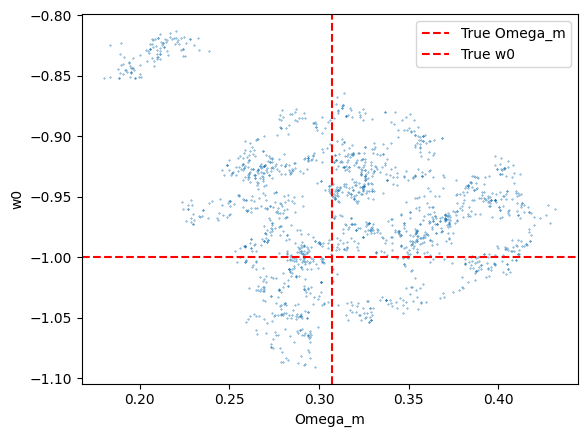

In [35]:
plt.scatter(samples_prod[:, :, 0].reshape(-1), samples_prod[:, :, 1].reshape(-1), s=0.1)
plt.axvline(x0[0], color="r", linestyle="--", label="True Omega_m")
plt.axhline(x0[1], color="r", linestyle="--", label="True w0")
plt.xlabel("Omega_m")
plt.ylabel("w0")
plt.legend()
plt.show()

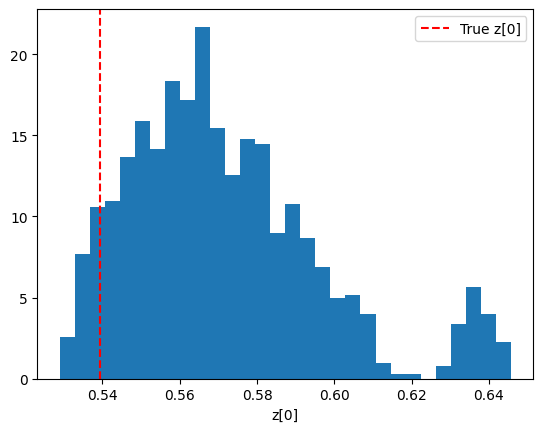

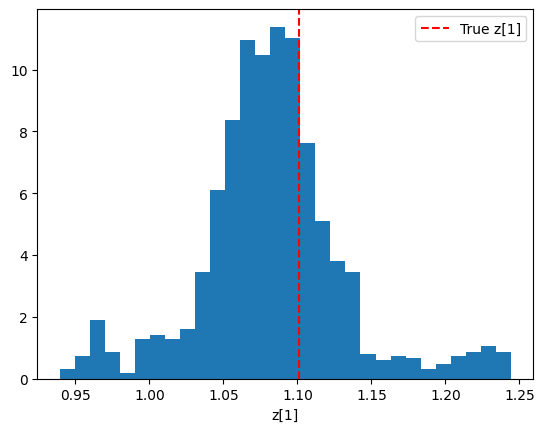

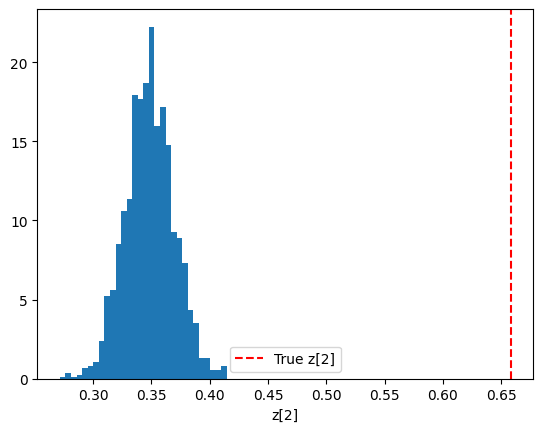

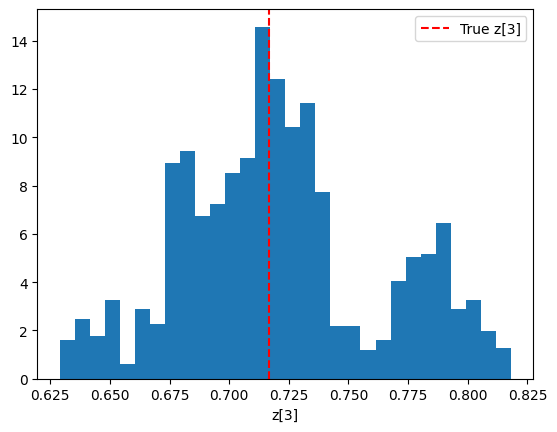

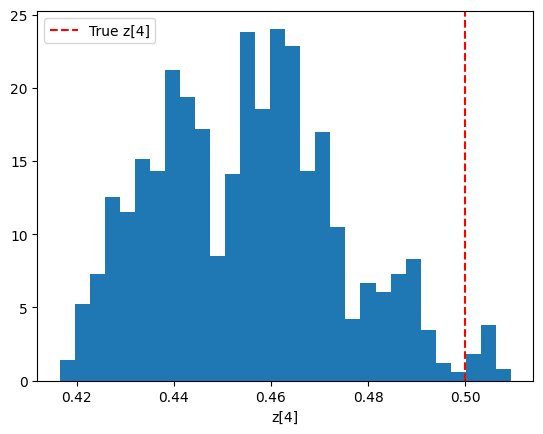

In [34]:
for i in range(5):
    plt.hist(samples_prod[:, :, 2 + i].reshape(-1), bins=30, density=True)
    plt.axvline(x0[2 + i], color="r", linestyle="--", label=f"True z[{i}]")
    plt.xlabel(f"z[{i}]")
    plt.legend()
    plt.show()